In [1]:
import sys
import math
from collections import namedtuple, defaultdict

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import pandas as pd
import numpy as np

from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter

import gym
import gym_atena.envs.atena_env_cont as atena_env_cont
from gym_atena.envs.atena_env_cont import ATENAEnvCont
import Configuration.config as cfg
%matplotlib inline

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Registering ATENAcont-v0 environment
Configuration loaded with:
  - humanity_coeff: 1.0
  - diversity_coeff: 2.0
  - kl_coeff: 1.5
  - compaction_coeff: 2.0
  - adam_lr: 0.0003
  - ppo_gamma: 0.995
  - ppo_lambda: 0.97
✅ Using Snorkel compatibility adapter


# VLDB Demo Graphs

Create publication-quality graphs for VLDB paper/demo.

## Load Training Curves

Load reward and humanity learning curves from TensorBoard exports.

In [2]:
# Load training curves from TensorBoard CSV exports
try:
    reward_df = pd.read_csv('reward_learning_curves/episode_reward/run_.-tag-episode_reward.csv',
                            sep=',',
                            dtype={'Step': np.uint32, 'Value': np.float64})
    humanity_df = pd.read_csv('reward_learning_curves/humanity_reward/run_.-tag-humanity.csv',
                            sep=',',
                            dtype={'Step': np.uint32, 'Value': np.float64})
    print(f" Loaded reward curve: {len(reward_df)} points")
    print(f" Loaded humanity curve: {len(humanity_df)} points")
except FileNotFoundError as e:
    print(f"  CSV files not found: {e}")
    print("To export from TensorBoard: results/*/logs/")
    reward_df = None
    humanity_df = None

✅ Loaded reward curve: 41666 points
✅ Loaded humanity curve: 41666 points


## Dual Plot: Reward and Humanity

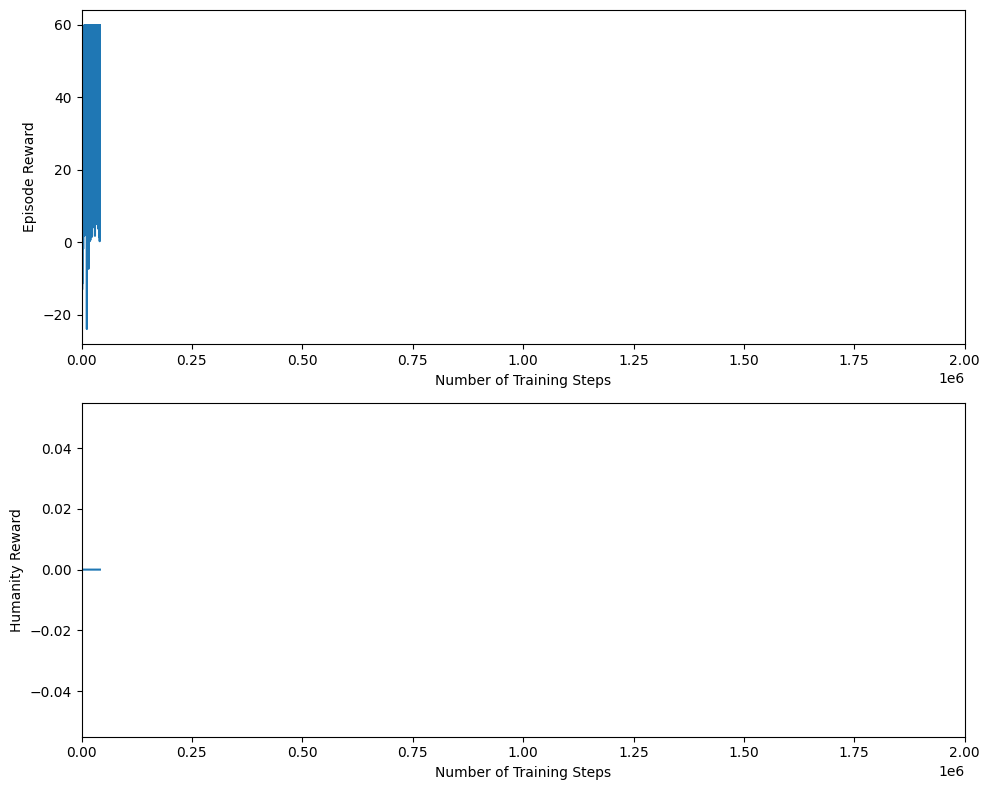

In [3]:
if reward_df is not None and humanity_df is not None:
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    # Episode reward
    ax1.set_xlim(0,2e6)
    ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    reward_df.plot(x='Step', y='Value', ax=ax1, legend=False)
    ax1.set_xlabel("Number of Training Steps")
    ax1.set_ylabel("Episode Reward")
    
    # Humanity reward
    humanity_df.plot(x='Step', y='Value', ax=ax2, legend=False)
    ax2.set_xlabel("Number of Training Steps")
    ax2.set_ylabel("Humanity Reward")
    ax2.set_xlim(0,2e6)
    ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.tight_layout()
    plt.show()

## Side-by-Side Comparison

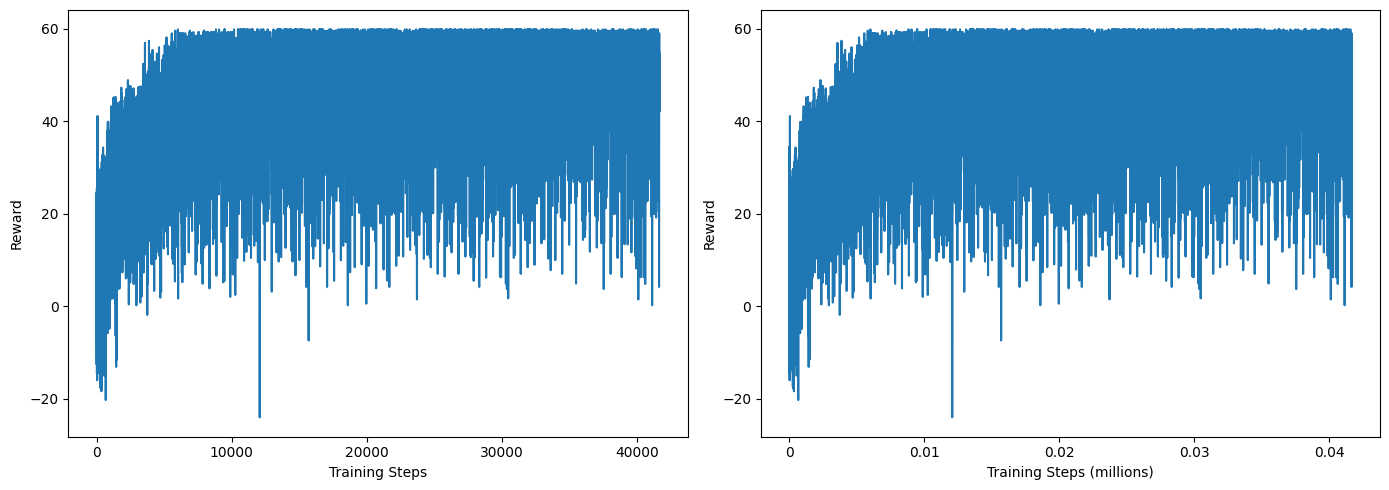

In [4]:
if reward_df is not None:
    x = reward_df.Step
    y = reward_df.Value

    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # Plot two versions
    ax1.plot(x, y)
    ax2.plot(x, y)

    # Format ax2 with scaled axes
    scale_x = 1e6
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
    ax2.xaxis.set_major_formatter(ticks_x)

    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Reward')
    ax2.set_xlabel('Training Steps (millions)')
    ax2.set_ylabel('Reward')

    plt.tight_layout()
    plt.show()

## Smoothed Humanity Curve

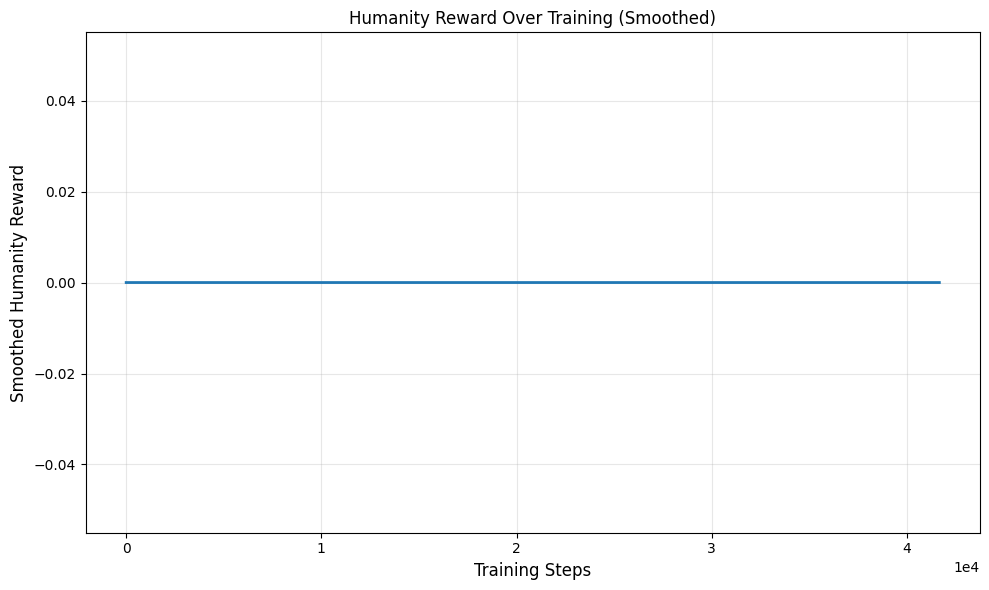

In [5]:
if humanity_df is not None:
    # Apply Savitzky-Golay filter for smoothing
    y_hat = savgol_filter(tuple(humanity_df.Value), 51, 3)

    plt.figure(figsize=(10, 6))
    plt.plot(humanity_df.Step, y_hat, linewidth=2)
    plt.xlabel('Training Steps', size=12)
    plt.ylabel('Smoothed Humanity Reward', size=12)
    plt.title('Humanity Reward Over Training (Smoothed)')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Reward Component Visualizations

In [6]:
def numerically_stable_normalized_sigmoid(a,b, x):
    """Numerically stable sigmoid function."""
    if b*(x-a) < 0:
        z = math.exp(b*(x-a))
        return 1 / (1 + z)
    else:
        z = math.exp(b*(-x+a))
        return z / (1 + z)
        
def normalized_sigmoid_fkt(a, b, x):
    return numerically_stable_normalized_sigmoid(a,b,x)

## Compaction Display Score

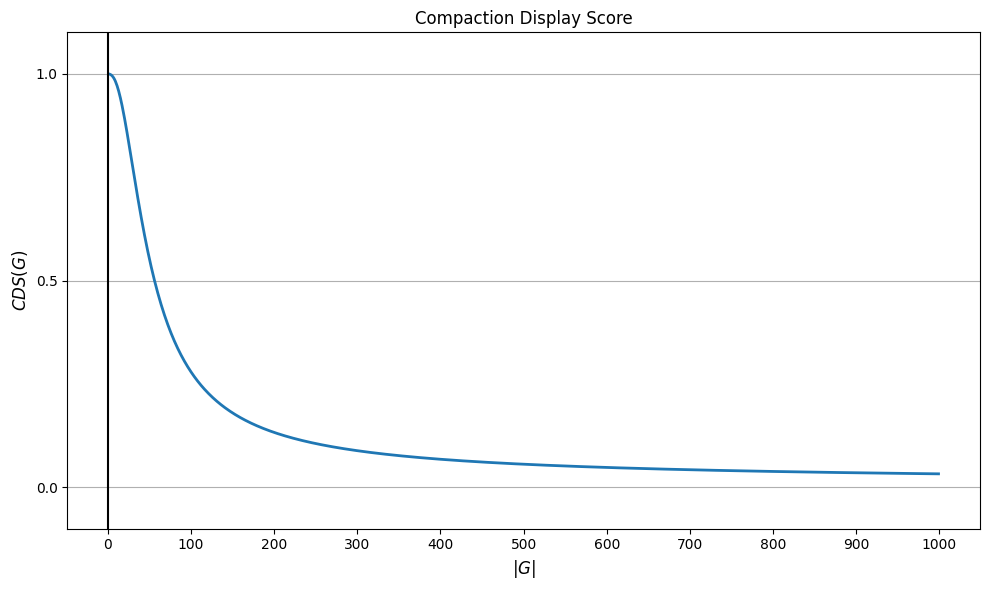

Saved: vldb_compaction_score.pdf


In [7]:
def compaction_display_score(G, denominator_epsilon=0.00001):
    return normalized_sigmoid_fkt(0.5, 17, 1 - 1 / math.log(8 + G + denominator_epsilon, 8))

max_G = 1000
Gs = np.arange(1, max_G, 1)
compaction_display_score_Gs = np.array([compaction_display_score(G) for G in range(1,max_G)])

plt.figure(figsize=(10, 6))
plt.plot(Gs, compaction_display_score_Gs, linewidth=2)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('$|G|$', size=12)
plt.ylabel('$CDS(G)$', size=12)
plt.title('Compaction Display Score')

plt.xticks([x*100 for x in range(11)])
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.savefig('vldb_compaction_score.pdf', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: vldb_compaction_score.pdf")

## Data Size Score

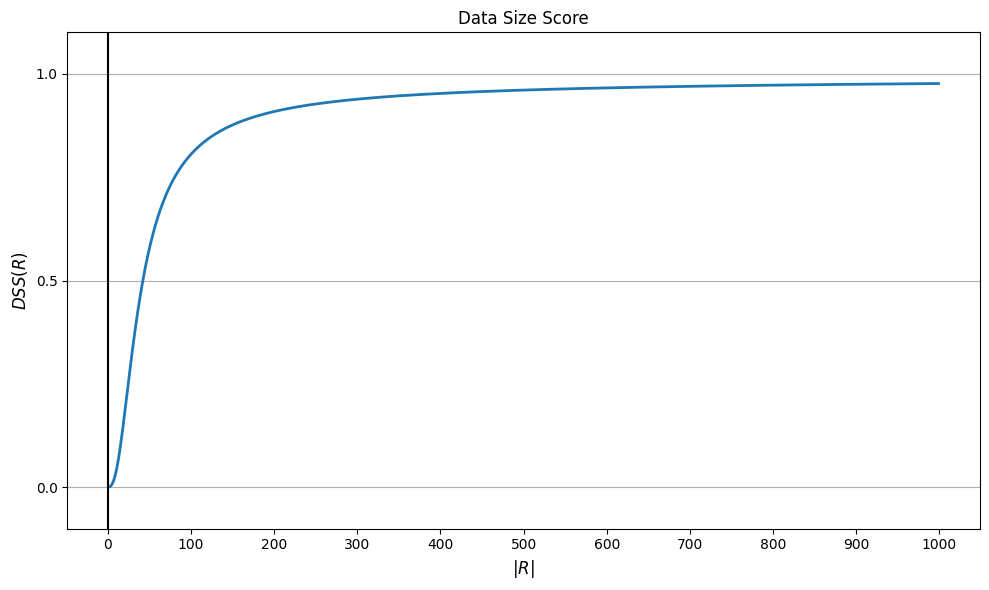

Saved: vldb_data_size_score.pdf


In [8]:
def data_size_score(R, denominator_epsilon=0.00001):
    return 1-normalized_sigmoid_fkt(0.5, 17, 1 - 1 / math.log(7 + R + denominator_epsilon, 7))

max_R = 1000
Rs = np.arange(1, max_R, 1)
data_size_score_Rs = np.array([data_size_score(R) for R in range(1,max_R)])

plt.figure(figsize=(10, 6))
plt.plot(Rs, data_size_score_Rs, linewidth=2)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('$|R|$', size=12)
plt.ylabel('$DSS(R)$', size=12)
plt.title('Data Size Score')

plt.xticks([x*100 for x in range(11)])
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.savefig('vldb_data_size_score.pdf', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: vldb_data_size_score.pdf")

## Publication-Ready Training Curve

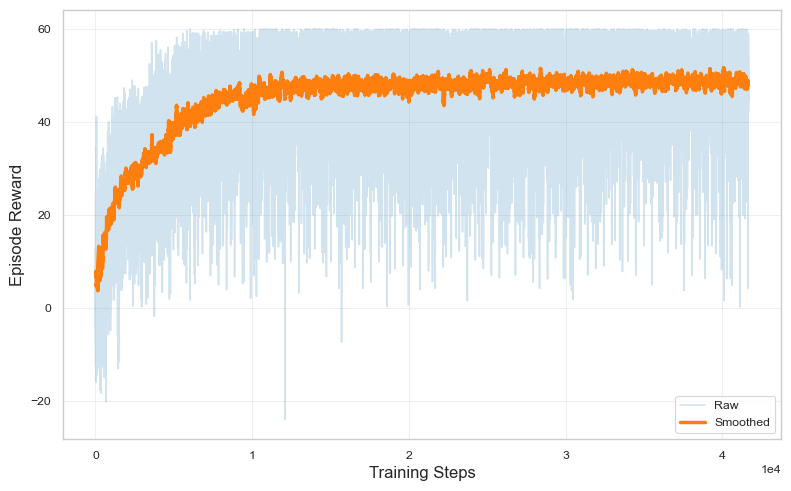

✅ Saved: vldb_training_curve.pdf


In [9]:
if reward_df is not None:
    # Create publication-ready figure
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Smooth curve
    window = min(50, len(reward_df) // 10)
    if window > 0:
        smoothed = reward_df['Value'].rolling(window=window, center=True).mean()
        
        # Plot raw and smoothed
        ax.plot(reward_df['Step'], reward_df['Value'], alpha=0.2, label='Raw')
        ax.plot(reward_df['Step'], smoothed, linewidth=2.5, label='Smoothed')
        
        ax.set_xlabel('Training Steps', fontsize=12)
        ax.set_ylabel('Episode Reward', fontsize=12)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('vldb_training_curve.pdf', dpi=300, bbox_inches='tight')
        plt.show()
        print(" Saved: vldb_training_curve.pdf")